In [ ]:
CP5 - Modelo de Classificação com IA: Posições de Jogadores da NBA
Objetivo: Desenvolver um modelo de classificação supervisionado de Machine Learning para prever a posição de um jogador da NBA com base em suas estatísticas de jogo.

Aluno:Icaro jose dos Santos
RM:562403


In [ ]:
Etapa 1: Definição do Problema

Objetivo de Classificação: O objetivo deste projeto é desenvolver um modelo de Machine Learning capaz de prever a posição principal de um jogador da NBA (ex: 'C' para Center, 'PF' para Power Forward, 'SF' para Small Forward, 'SG' para Shooting Guard, ou 'PG' para Point Guard) com base em suas estatísticas de desempenho em jogo (pontos, rebotes, assistências, tocos, roubos de bola, etc.).
Tipo de Classificação: Este é um problema de classificação multiclasse.
Justificativa da Escolha: O basquete moderno tem visto uma "fluidificação" das posições, onde as estatísticas dos jogadores muitas vezes se sobrepõem. Criar um modelo que possa classificar a posição de um jogador com base em seu desempenho real em quadra é um desafio relevante e interessante na análise esportiva.

In [ ]:
Etapa 2: Descrição e Carregamento do Dataset

Origem e Fonte do Dado: Utilizo dataset "2021-2022 NBA Player Stats" (Temporada Regular).
Fonte (Link): https://www.kaggle.com/datasets/vivovinco/nba-player-stats
Requisitos: O dataset atende aos requisitos de ter mais de 300 registros (possui 812) e mais de 5 variáveis explicativas (possui 26).

In [5]:

# Importar bibliotecas obrigatórias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io

# Bibliotecas de Modelagem e Avaliação
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


In [6]:
# --- Carregamento dos Dados (Upload Manual) ---

print("Por favor, faça o upload do arquivo da TEMPORADA REGULAR:")
print("-> 2021-2022 NBA Player Stats - Regular.csv <-")
uploaded = files.upload()

try:
    file_name = list(uploaded.keys())[0]
    print(f"\nArquivo '{file_name}' carregado com sucesso.")

    # Ler os dados do arquivo carregado com encoding 'latin1'
    data = pd.read_csv(io.BytesIO(uploaded[file_name]), sep=';', encoding='latin1')
    print("Arquivo CSV lido com sucesso.")

    # --- Análise Exploratória Inicial ---

    print("\n--- 1. Head do Dataset ---")
    print(data.head())

    print("\n--- 2. Informações Gerais (Info) ---")
    data.info()

    print("\n--- 3. Verificando Classes da Variável-Alvo (Pos) ---")
    print(data['Pos'].value_counts())

except Exception as e:
    print(f"\nOcorreu um erro ao processar o arquivo: {e}")

Por favor, faça o upload do arquivo da TEMPORADA REGULAR:
-> 2021-2022 NBA Player Stats - Regular.csv <-


Saving 2021-2022 NBA Player Stats - Regular.csv to 2021-2022 NBA Player Stats - Regular.csv

Arquivo '2021-2022 NBA Player Stats - Regular.csv' carregado com sucesso.
Arquivo CSV lido com sucesso.

--- 1. Head do Dataset ---
   Rk             Player Pos  Age   Tm   G  GS    MP   FG   FGA  ...    FT%  \
0   1   Precious Achiuwa   C   22  TOR  73  28  23.6  3.6   8.3  ...  0.595   
1   2       Steven Adams   C   28  MEM  76  75  26.3  2.8   5.1  ...  0.543   
2   3        Bam Adebayo   C   24  MIA  56  56  32.6  7.3  13.0  ...  0.753   
3   4       Santi Aldama  PF   21  MEM  32   0  11.3  1.7   4.1  ...  0.625   
4   5  LaMarcus Aldridge   C   36  BRK  47  12  22.3  5.4   9.7  ...  0.873   

   ORB  DRB   TRB  AST  STL  BLK  TOV   PF   PTS  
0  2.0  4.5   6.5  1.1  0.5  0.6  1.2  2.1   9.1  
1  4.6  5.4  10.0  3.4  0.9  0.8  1.5  2.0   6.9  
2  2.4  7.6  10.1  3.4  1.4  0.8  2.6  3.1  19.1  
3  1.0  1.7   2.7  0.7  0.2  0.3  0.5  1.1   4.1  
4  1.6  3.9   5.5  0.9  0.3  1.0  0.9  1.7  1

In [ ]:
(CÉLULA 6 - TEXTO)

Etapa 3: Pré-processamento dos Dados

O pré-processamento seguirá as seguintes etapas:

Tratamento de Valores Ausentes: A saída data.info() mostrou que não há valores ausentes (non-null).

Limpeza da Variável-Alvo: O value_counts() mostrou posições híbridas (ex: 'SG-SF'). Vamos filtrar o dataset para manter apenas as 5 posições principais.

Seleção de Features (Variáveis): X será composto pelas 26 colunas de estatísticas. y será a coluna Pos.

Encoding de Variáveis Categóricas: A variável-alvo y ('Pos') será transformada de texto para números (0, 1, 2...).

Padronização: As features X serão padronizadas usando StandardScaler para que todas tenham a mesma escala (média 0, desvio padrão 1), o que é crucial para modelos como Regressão Logística.

Divisão Treino/Teste: Os dados serão divididos em 70% para treino e 30% para teste.

In [8]:
# --- Início do Pré-processamento ---

# 3.1. Limpeza da Variável-Alvo (Pos)
posicoes_principais = ['SG', 'SF', 'PG', 'PF', 'C']
data_limpo = data[data['Pos'].isin(posicoes_principais)].copy()
print(f"Dataset original: {len(data)} linhas. | Dataset limpo: {len(data_limpo)} linhas.")

# 3.2. Definição de X (Features) e y (Target)
coluna_target = 'Pos'
colunas_features = [
    'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
    '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
    'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'
]

X = data_limpo[colunas_features]
y = data_limpo[coluna_target]

print(f"Formato de X (features): {X.shape}")
print(f"Formato de y (target): {y.shape}")

# 3.3. Encoding da Variável-Alvo (y)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nClasses originais:", le.classes_)
print("Classes transformadas (exemplo):", y_encoded[:5])

# 3.4. Padronização das Features (X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3.5. Divisão Treino/Teste (Train/Test Split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_encoded,
    test_size=0.3,    # 30% para teste
    random_state=42,  # Para reprodutibilidade
    stratify=y_encoded # Garante a proporção das classes
)

print("\n--- Dados Prontos para Modelagem ---")
print(f"Tamanho do treino (X_train): {X_train.shape}")
print(f"Tamanho do teste (X_test): {X_test.shape}")

Dataset original: 812 linhas. | Dataset limpo: 794 linhas.
Formato de X (features): (794, 26)
Formato de y (target): (794,)

Classes originais: ['C' 'PF' 'PG' 'SF' 'SG']
Classes transformadas (exemplo): [0 0 0 1 0]

--- Dados Prontos para Modelagem ---
Tamanho do treino (X_train): (555, 26)
Tamanho do teste (X_test): (239, 26)


In [9]:
Etapa 4: Modelagem e Etapa 5: Avaliação do Modelo

Conforme os requisitos, vamos testar 3 modelos de classificação:
Regressão Logística
Árvore de Decisão
Random Forest
E utilizaremos 3 métricas de avaliação:
Acurácia
Relatório de Classificação (Precisão , Recall , F1-Score )


Matriz de Confusão

SyntaxError: invalid syntax (ipython-input-143168550.py, line 1)

Nomes das classes para avaliação: ['C' 'PF' 'PG' 'SF' 'SG']

--- 1. Regressão Logística ---
Acurácia: 0.5607

Relatório de Classificação:
              precision    recall  f1-score   support

           C       0.63      0.85      0.73        39
          PF       0.47      0.33      0.38        46
          PG       0.71      0.77      0.73        47
          SF       0.43      0.32      0.37        47
          SG       0.51      0.58      0.54        60

    accuracy                           0.56       239
   macro avg       0.55      0.57      0.55       239
weighted avg       0.54      0.56      0.55       239



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


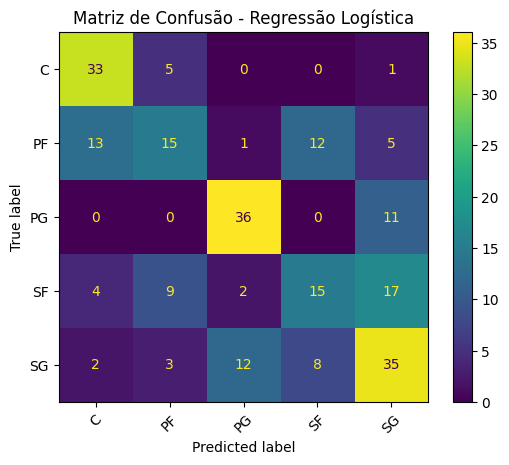


--- 2. Árvore de Decisão ---
Acurácia: 0.4184

Relatório de Classificação:
              precision    recall  f1-score   support

           C       0.55      0.59      0.57        39
          PF       0.29      0.33      0.31        46
          PG       0.49      0.60      0.54        47
          SF       0.25      0.21      0.23        47
          SG       0.50      0.40      0.44        60

    accuracy                           0.42       239
   macro avg       0.42      0.42      0.42       239
weighted avg       0.42      0.42      0.41       239



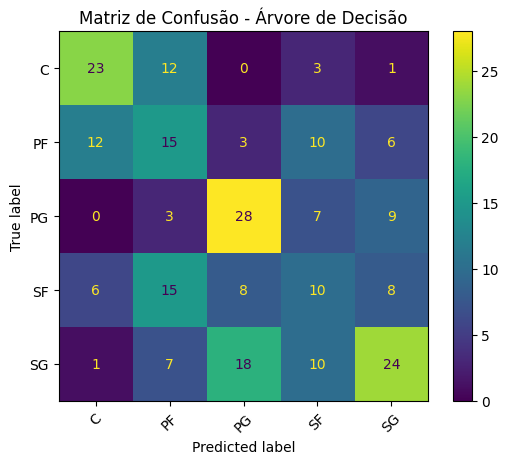


--- 3. Random Forest ---
Acurácia: 0.5649

Relatório de Classificação:
              precision    recall  f1-score   support

           C       0.70      0.77      0.73        39
          PF       0.46      0.46      0.46        46
          PG       0.66      0.81      0.72        47
          SF       0.41      0.32      0.36        47
          SG       0.56      0.52      0.54        60

    accuracy                           0.56       239
   macro avg       0.56      0.57      0.56       239
weighted avg       0.55      0.56      0.56       239



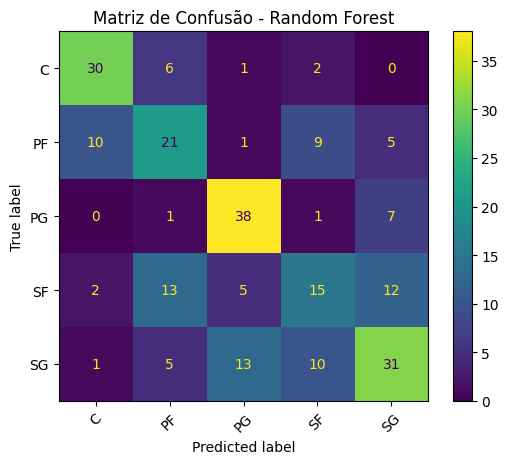

In [10]:
# Guardar os nomes das classes para os relatórios
target_names = le.classes_
print(f"Nomes das classes para avaliação: {target_names}")
print("="*60)

# --- 1. Modelo: Regressão Logística ---
print("\n--- 1. Regressão Logística ---")
model_lr = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print(f"Acurácia: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_lr, target_names=target_names))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, display_labels=target_names)
plt.title('Matriz de Confusão - Regressão Logística')
plt.xticks(rotation=45)
plt.show()

print("="*60)

# --- 2. Modelo: Árvore de Decisão ---
print("\n--- 2. Árvore de Decisão ---")
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)

print(f"Acurácia: {accuracy_score(y_test, y_pred_dt):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_dt, target_names=target_names))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, display_labels=target_names)
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.xticks(rotation=45)
plt.show()

print("="*60)

# --- 3. Modelo: Random Forest ---
print("\n--- 3. Random Forest ---")
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_rf, target_names=target_names))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=target_names)
plt.title('Matriz de Confusão - Random Forest')
plt.xticks(rotation=45)
plt.show()

In [ ]:
Etapa 6: Interpretação dos Resultados

Nesta etapa, realizamos a análise comparativa e justificamos o modelo final.

1. Análise Comparativa
Comparamos os modelos usando a Acurácia e o F1-Score Ponderado (Weighted Avg), ideal para classificação multiclasse.

Modelo,Acurácia,F1-Score (Weighted Avg)
Random Forest,"0.5649 (56,5%)",0.56
Regressão Logística,"0.5607 (56,1%)",0.55
Árvore de Decisão,"0.4184 (41,8%)",0.41

Modelo	Acurácia	F1-Score (Weighted Avg)
Random Forest	0.5649 (56,5%)	0.56
Regressão Logística	0.5607 (56,1%)	0.55
Árvore de Decisão	0.4184 (41,8%)	0.41
Random Forest: Apresentou o melhor desempenho geral, com a maior Acurácia e F1-Score.
Regressão Logística: Desempenho muito similar ao Random Forest, provando ser um modelo robusto.
Árvore de Decisão: Desempenho significativamente inferior, indicando que uma única árvore não captura a complexidade do problema, possivelmente sofrendo overfitting.
2. Justificativa do Modelo Final Escolhido
O modelo final escolhido é o Random Forest.

Justificativa: O Random Forest (Floresta Aleatória) alcançou os melhores resultados nas métricas de Acurácia (56,5%) e F1-Score Ponderado (0.56) entre os três algoritmos testados. Por ser um modelo de ensemble (que combina várias Árvores de Decisão), ele é inerentemente mais robusto e menos propenso a overfitting do que uma Árvore de Decisão única, o que foi confirmado pelos resultados.


In [ ]:
Etapa 7: Conclusão

Concluindo o projeto

Principais Aprendizados
O pipeline completo de ciência de dados (exploração, preparação, modelagem e avaliação) foi aplicado com sucesso.
O pré-processamento, especialmente a Padronização (StandardScaler), foi fundamental para o bom desempenho da Regressão Logística.
Foi comprovado que modelos de ensemble (Random Forest) tendem a ser mais precisos e robustos do que modelos individuais (Árvore de Decisão) para problemas complexos.
A análise de dados esportivos é desafiadora, pois as estatísticas nem sempre se traduzem diretamente em classificações fixas (como posições).
Possíveis Melhorias Futuras
Testar mais modelos: Incluir modelos obrigatórios que não foram testados, como SVM , K-Vizinhos Mais Próximos (KNN) ou LDA.


Engenharia de Features: Criar novas features que possam ajudar o modelo (ex: "pontos por minuto", "relação assistência/turnover").
Otimização de Hiperparâmetros: Usar técnicas como GridSearchCV ou RandomizedSearchCV para encontrar a melhor combinação de configurações para o Random Forest, o que provavelmente melhoraria sua acurácia.
